# 1. 데이터 준비

## 필수패키지 설치

In [ ]:
!pip install PublicDataReader
!pip install PublicDataReader --upgrade
!pip install finance-datareader
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
! pip install category_encoders
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import FinanceDataReader as fdr
import PublicDataReader as pdr
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumBarunGothic') 
mpl.rc('axes', unicode_minus=False)
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000
%matplotlib inline
%config InlineBackend.figure_format='retina'

Requirement already up-to-date: PublicDataReader in /usr/local/lib/python3.7/dist-packages (2021.1.9)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: no

## 1.1 데이터 수집 및 랭글링

In [ ]:
## data 불러오기
data = pd.read_csv('/content/drive/MyDrive/final_data (1).csv')
df = data.copy()
df = df.drop(columns=['Unnamed: 0','거래일'])
num_feature = ['세대','인구','자동차등록','인구이동(전입지별)',
               '출생아수(명)', '사망자수(명)' ,'혼인건수(건)','이혼건수(건)']
for col in num_feature:
  df[col] = df[col].str.replace(",","").astype(int)
df['평당가'] = df['거래금액'] / df['전용면적']
df['거래횟수'] = [1]*len(df.index)

In [ ]:
## 구별K 선정
from sklearn.cluster import KMeans
구별랭킹 = pd.concat([df.groupby('지역코드').mean()[['평당가','거래금액']].sort_values('평당가',ascending=False),                 
                      df.groupby('지역코드').sum()[['거래횟수']]],
                      axis = 1)
kmeans = KMeans(n_clusters=5)
kmeans.fit(구별랭킹)
구별랭킹['구별K'] = kmeans.labels_
구별랭킹

,평당가,거래금액,거래횟수,구별K
강남구,1965.900547,172790.735915,12265,3
서초구,1726.341862,163525.710964,9850,3
송파구,1423.073380,117229.070079,15240,1
용산구,1417.798535,145481.003948,4812,3
성동구,1266.980612,98494.772688,9344,4
마포구,1191.961147,90848.400701,8842,4
광진구,1114.909593,93132.966703,4535,4
동작구,1071.001067,85849.420518,8461,4
영등포구,1029.975473,78392.765241,10121,2
강동구,1027.079886,75117.814662,12399,2


In [ ]:
## 매핑
gu_mapper = {gu:k for gu,k in zip(구별랭킹.index,구별랭킹.구별K)}
df['구별K'] = df['지역코드'].copy()
df['구별K'] = df['구별K'].replace(gu_mapper)

In [ ]:
## 컬럼명 지정 및 drop
dataset = df.drop(columns=['거래횟수','평당가','지번','-\xa0집세'])
dataset.columns = ['지역코드', '법정동', '아파트', '전용면적', '층', '건축년도', '거래금액', '거래년도', '거래월일', '세대',
       '인구', '세대당인구', '자동차등록', '인구이동(전입지별)', '외국인증권투자', '국고채 3년(평균)',
       '국고채 5년(평균)', '국고채 10년(평균)', '회사채 3년(평균)', 'CD 91물(평균)', '콜금리(1일물,평균)',
       '소비자물가', '- 농축수산물', '- 공업제품', '- 공공서비스', '- 개인서비스', '근원물가', '출생아수(명)',
       '사망자수(명)', '혼인건수(건)', '이혼건수(건)', 'KS11', 'KQ11', 'DJI', 'IXIC', 'VIX',
       'CSI300', 'SSEC', 'DE30', 'FCHI', 'NG', 'GC', 'HG', 'CL', '구별K']

dataset = dataset.drop(columns=['세대당인구','국고채 3년(평균)','국고채 5년(평균)','- 개인서비스','콜금리(1일물,평균)','CSI300','HG'])

In [ ]:
## engine함수
def engine(xxx):
  xxx['KRX'] = xxx.KS11 + xxx.KQ11
  xxx = xxx.drop(columns=['KS11','KQ11'])
  return xxx

In [ ]:
df.shape

(244456, 49)

In [ ]:
## dataset에 적용
DF_1 = engine(dataset.copy())
DF_1.shape

(244456, 37)

In [ ]:
dataset = DF_1

# 2. 모델링

## 2.1 훈련 검증 테스트

In [ ]:
## 2021년 기준으로 분리
target='거래금액'
train = dataset[(dataset.거래월일 != '2021-01') | (dataset.거래월일 != '2021-02')].copy()
test = dataset[(dataset.거래월일 == '2021-01') | (dataset.거래월일 == '2021-02')].copy()
print(train.shape,test.shape)
print(test.거래월일.value_counts())

(244456, 37) (5248, 37)
2021-01    4826
2021-02     422
Name: 거래월일, dtype: int64


In [ ]:
## 2021년 이전 데이터를 훈련, 검증셋으로 분리
X = train.drop(columns=target)
y = train[target]
X_test = test.drop(columns=target)
y_test = test[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

## 2.2 LGBM

In [ ]:
## 모델은 LGBM으로 선정
from lightgbm import LGBMRegressor
pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor()
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9326590653021218
검증 R^2:  0.9269560422813437
TEST R^2:  0.9157480752961789

훈련 MAE:  9753.15598992995
검증 MAE:  9949.212051390085
TEST MAE:  13514.29630264313


## 2.3 TUNE

In [ ]:
## 인코딩
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [ ]:
## 파라미터 튜닝
lightGB = LGBMRegressor(learning_rate=0.01, max_depth=15, n_estimators=300000, num_leaves=250,
                      random_state=1, reg_alpha=1, reg_lambda=1, subsample=0.7)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded,y_val), 
            (X_test_encoded, y_test)]

lightGB.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=1000,
          eval_metric='mae',
          verbose=100
         )

Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 18355.6	training's l2: 6.78441e+08	valid_1's l1: 18536	valid_1's l2: 7.01726e+08	valid_2's l1: 24222.4	valid_2's l2: 1.29154e+09
[200]	training's l1: 11779.5	training's l2: 2.73829e+08	valid_1's l1: 12084.5	valid_1's l2: 3.00897e+08	valid_2's l1: 16694.3	valid_2's l2: 5.64037e+08
[300]	training's l1: 9229.21	training's l2: 1.7319e+08	valid_1's l1: 9613.82	valid_1's l2: 2.0364e+08	valid_2's l1: 13430.3	valid_2's l2: 3.5566e+08
[400]	training's l1: 7994.8	training's l2: 1.33862e+08	valid_1's l1: 8428.5	valid_1's l2: 1.66553e+08	valid_2's l1: 11666	valid_2's l2: 2.72177e+08
[500]	training's l1: 7275.69	training's l2: 1.13551e+08	valid_1's l1: 7744.67	valid_1's l2: 1.47611e+08	valid_2's l1: 10542	valid_2's l2: 2.2754e+08
[600]	training's l1: 6751.49	training's l2: 9.96561e+07	valid_1's l1: 7247.29	valid_1's l2: 1.34834e+08	valid_2's l1: 9923.58	valid_2's l2: 2.03788e+08
[700]	training's l1: 6309.75	trainin

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300000, n_jobs=-1, num_leaves=250, objective=None,
              random_state=1, reg_alpha=1, reg_lambda=1, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
## 예측측
y_train_pred = lightGB.predict(X_train_encoded)
y_val_pred = lightGB.predict(X_val_encoded)
y_test_pred = lightGB.predict(X_test_encoded)

## 2.4 예측값과 실제값

In [ ]:
len(y_test_pred),len(y_test) # 개수 확인

(5248, 5248)

In [ ]:
## 검증 및 테스트
from sklearn.metrics import r2_score
print('훈련 R2 : ',r2_score(y_train,y_train_pred))
print('검증 R2 : ',r2_score(y_val,y_val_pred))
print('TEST R2 : ',r2_score(y_test,y_test_pred))

In [ ]:
## 검증 및 테스트
print('훈련 MAE : ',mean_absolute_error(y_train,y_train_pred))
print('검증 MAE : ',mean_absolute_error(y_val,y_val_pred))
print('TEST MAE : ',mean_absolute_error(y_test,y_test_pred))

훈련 MAE :  1755.0106281860456
검증 MAE :  3961.2761049586347
TEST MAE :  2971.030790171767


In [ ]:
X_test.columns # 컬럼 확인

Index(['지역코드', '법정동', '아파트', '전용면적', '층', '건축년도', '거래년도', '거래월일', '세대', '인구',
       '자동차등록', '인구이동(전입지별)', '외국인증권투자', '국고채 10년(평균)', '회사채 3년(평균)',
       'CD 91물(평균)', '소비자물가', '- 농축수산물', '- 공업제품', '- 공공서비스', '근원물가',
       '출생아수(명)', '사망자수(명)', '혼인건수(건)', '이혼건수(건)', 'DJI', 'IXIC', 'VIX',
       'SSEC', 'DE30', 'FCHI', 'NG', 'GC', 'CL', '구별K', 'KRX'],
      dtype='object')

In [ ]:
## 테스트의 예측값 비교 (loss 산출)
df_pred = pd.DataFrame(y_test)
df_pred = df_pred.reset_index(drop=True)
df_pred['예측금액'] = y_test_pred
df_pred['차이'] = df_pred['거래금액'] - df_pred['예측금액']
df_pred['차이(%)'] = df_pred['차이']/df_pred['거래금액']*100
df_pred[['지역코드', '법정동', '아파트', '전용면적', '층', '건축년도', '거래월일']] = X_test.reset_index()[['지역코드', '법정동', '아파트', '전용면적', '층', '건축년도', '거래월일']]
df_pred['count'] = [1]*len(y_test_pred)
df_pred

,거래금액,예측금액,차이,차이(%),지역코드,법정동,아파트,전용면적,층,건축년도,거래월일,count
0,127000,128299.512747,-1299.512747,-1.023238,종로구,견지동,대성스카이렉스,149.800,11,2008,2021-01,1
1,114000,113347.852677,652.147323,0.572059,종로구,교북동,경희궁자이(4단지),45.879,17,2017,2021-01,1
2,175000,174375.169849,624.830151,0.357046,종로구,내수동,경희궁의아침2단지,174.550,4,2004,2021-01,1
3,180000,178355.659000,1644.341000,0.913523,종로구,내수동,경희궁의아침3단지,123.130,13,2004,2021-01,1
4,63000,62455.291803,544.708197,0.864616,종로구,명륜1가,송림아마레스아파트,84.620,1,2003,2021-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5243,53000,54080.754291,-1080.754291,-2.039159,강동구,성내동,로얄,75.680,1,2003,2021-02,1
5244,34900,36400.348433,-1500.348433,-4.298993,강동구,성내동,다성이즈빌 아파트,27.150,12,2016,2021-02,1
5245,55000,55235.402578,-235.402578,-0.428005,강동구,암사동,중앙하이츠,59.520,6,1998,2021-02,1
5246,168000,165701.309769,2298.690231,1.368268,강동구,암사동,롯데캐슬퍼스트,112.110,2,2008,2021-02,1


In [ ]:
## 구별 차이 산출
pd.concat([df_pred.groupby('지역코드').mean().drop(columns='count'),df_pred.groupby('지역코드').sum()['count']],axis=1)

,거래금액,예측금액,차이,차이(%),전용면적,층,건축년도,count
지역코드,,,,,,,,
강남구,182365.362776,182771.434278,-406.071502,-1.420700,87.667700,8.996845,1999.444795,317
강동구,100335.347985,100383.228135,-47.880149,-1.482709,70.626753,9.802198,2005.468864,273
강북구,62229.320388,62322.290585,-92.970196,-0.408005,69.174912,7.941748,2004.601942,103
강서구,77377.275748,77460.619605,-83.343857,-0.938585,70.035924,7.813953,2001.202658,301
관악구,72183.588235,72272.341751,-88.753515,-0.680401,72.708786,9.711765,2002.300000,170
광진구,115427.528090,115024.146308,403.381782,-1.094486,77.349899,10.000000,2000.258427,89
구로구,59989.340625,60149.380706,-160.040081,-0.859323,66.163193,9.440625,1999.471875,320
금천구,58558.304348,59068.181405,-509.877058,-1.456910,67.587861,10.930435,2003.826087,115
노원구,62249.908088,62290.580053,-40.671965,-0.461227,62.381403,7.838235,1994.027574,544


## 2.5 시각화

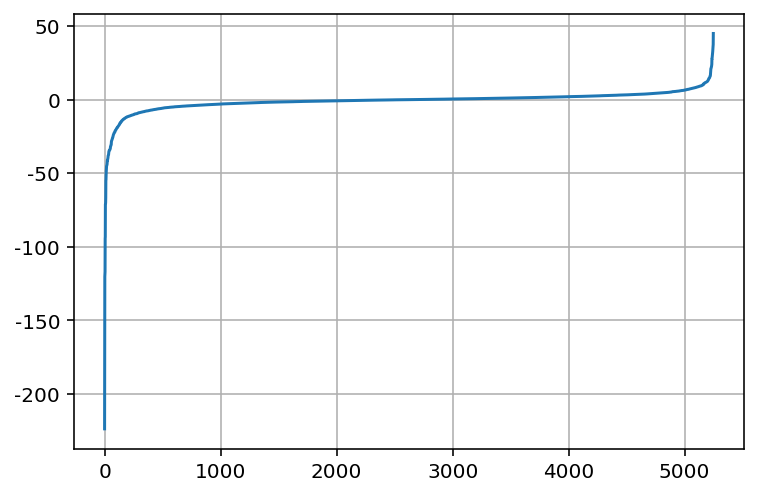

In [ ]:
## 테스트 결과 시각화 (plot)
df_pred.sort_values('차이(%)').reset_index()['차이(%)'].plot()

findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans.


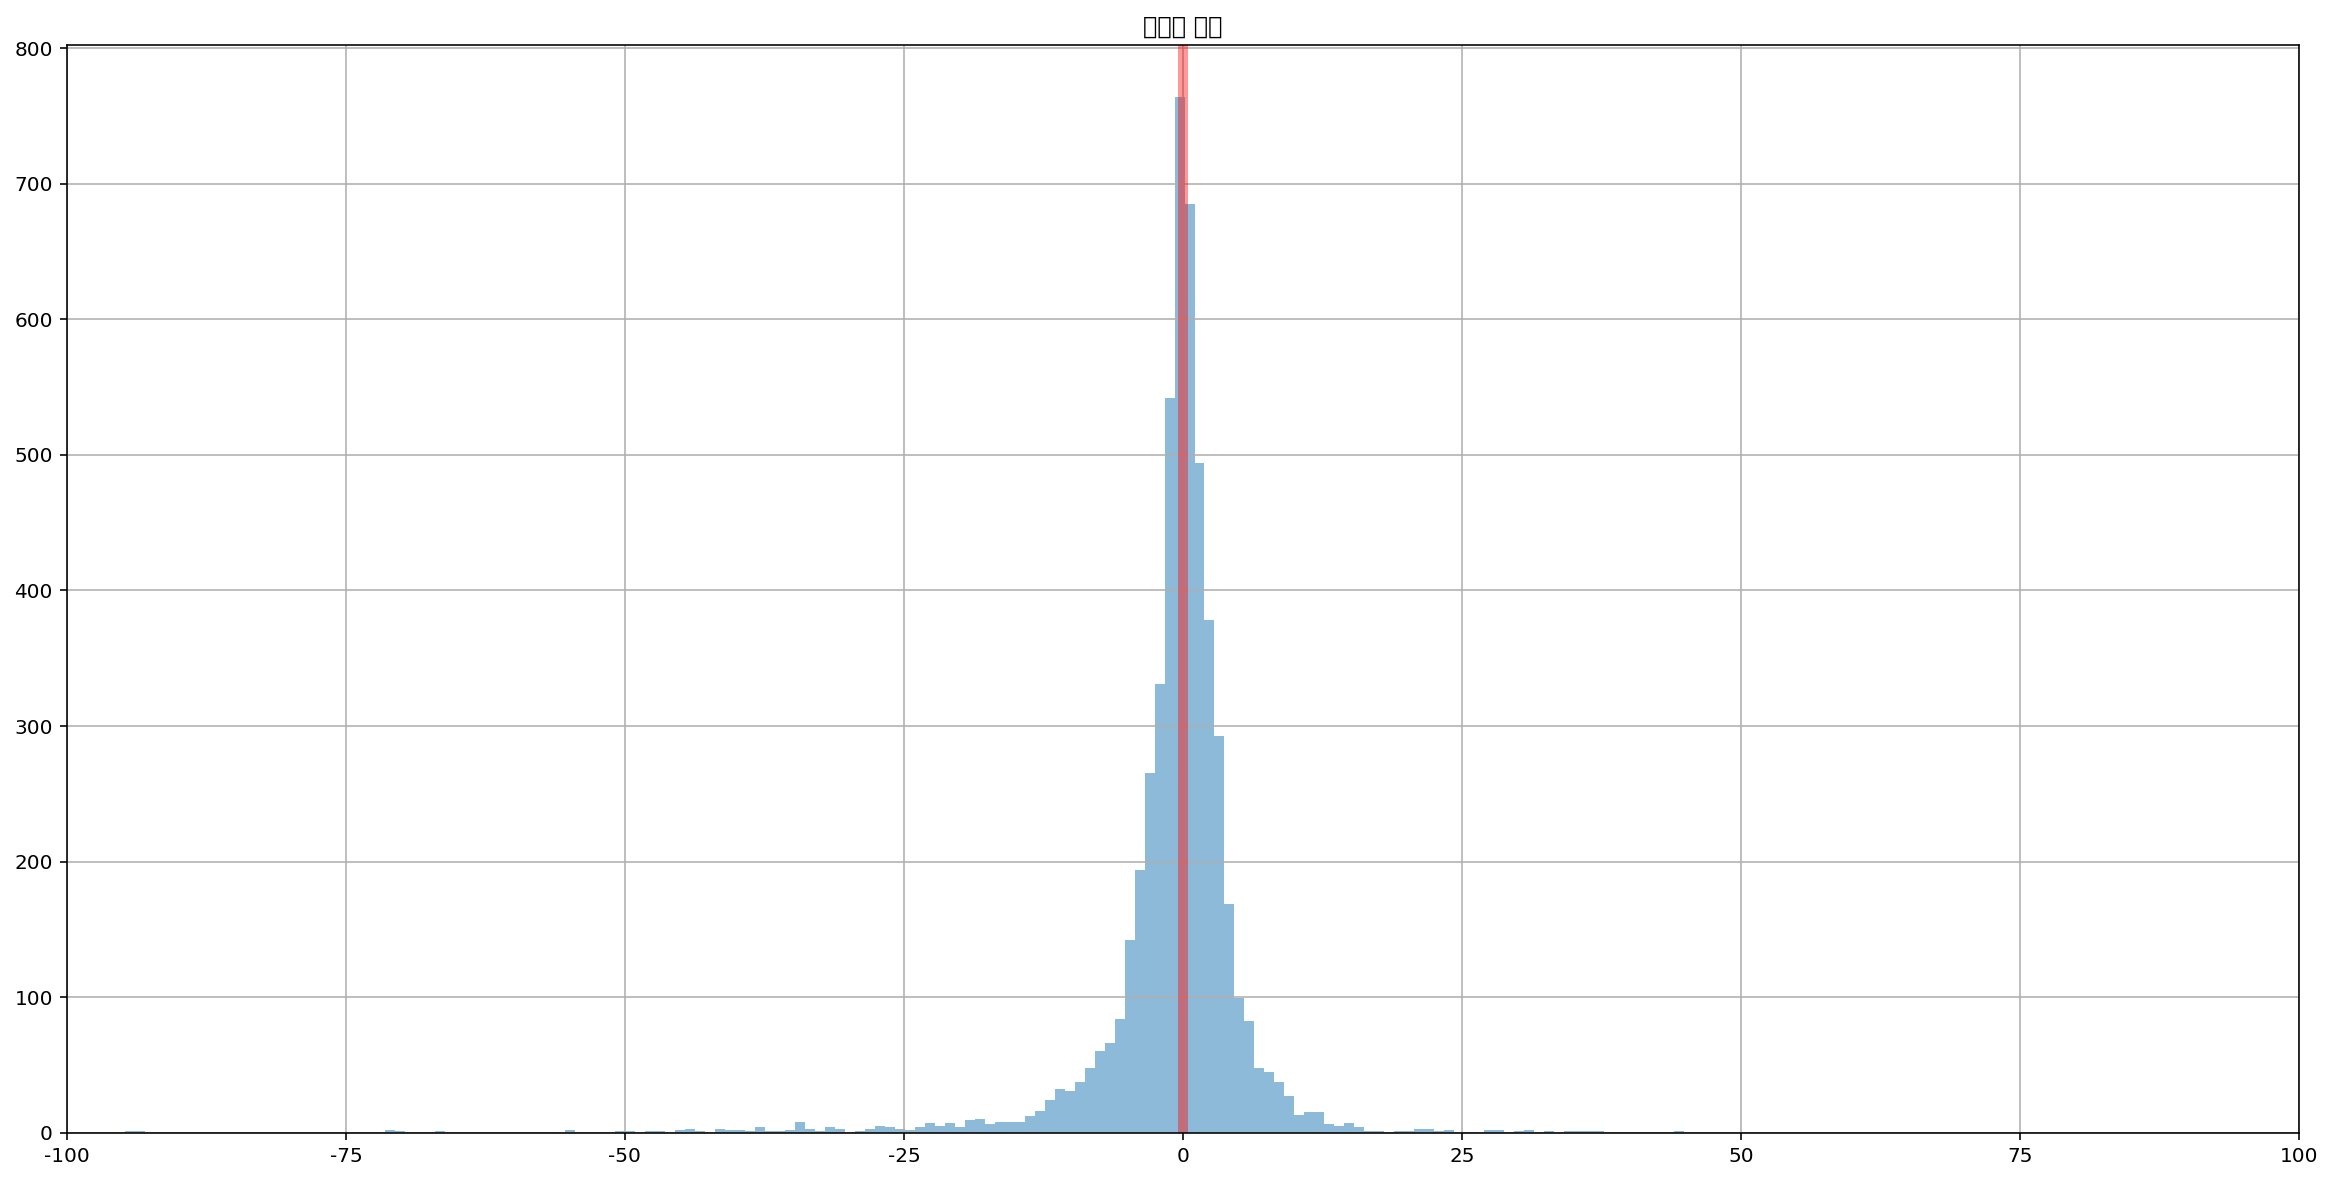

In [ ]:
## 테스트 결과 시각화 (dist)
plt.figure(figsize=(20,10))
plt.xlim(-100,100)
plt.axvline(0,color='r',alpha=0.4,linewidth=5)
plt.title('오차의 분포')
df_pred['차이(%)'].hist(bins=300,alpha=0.5)

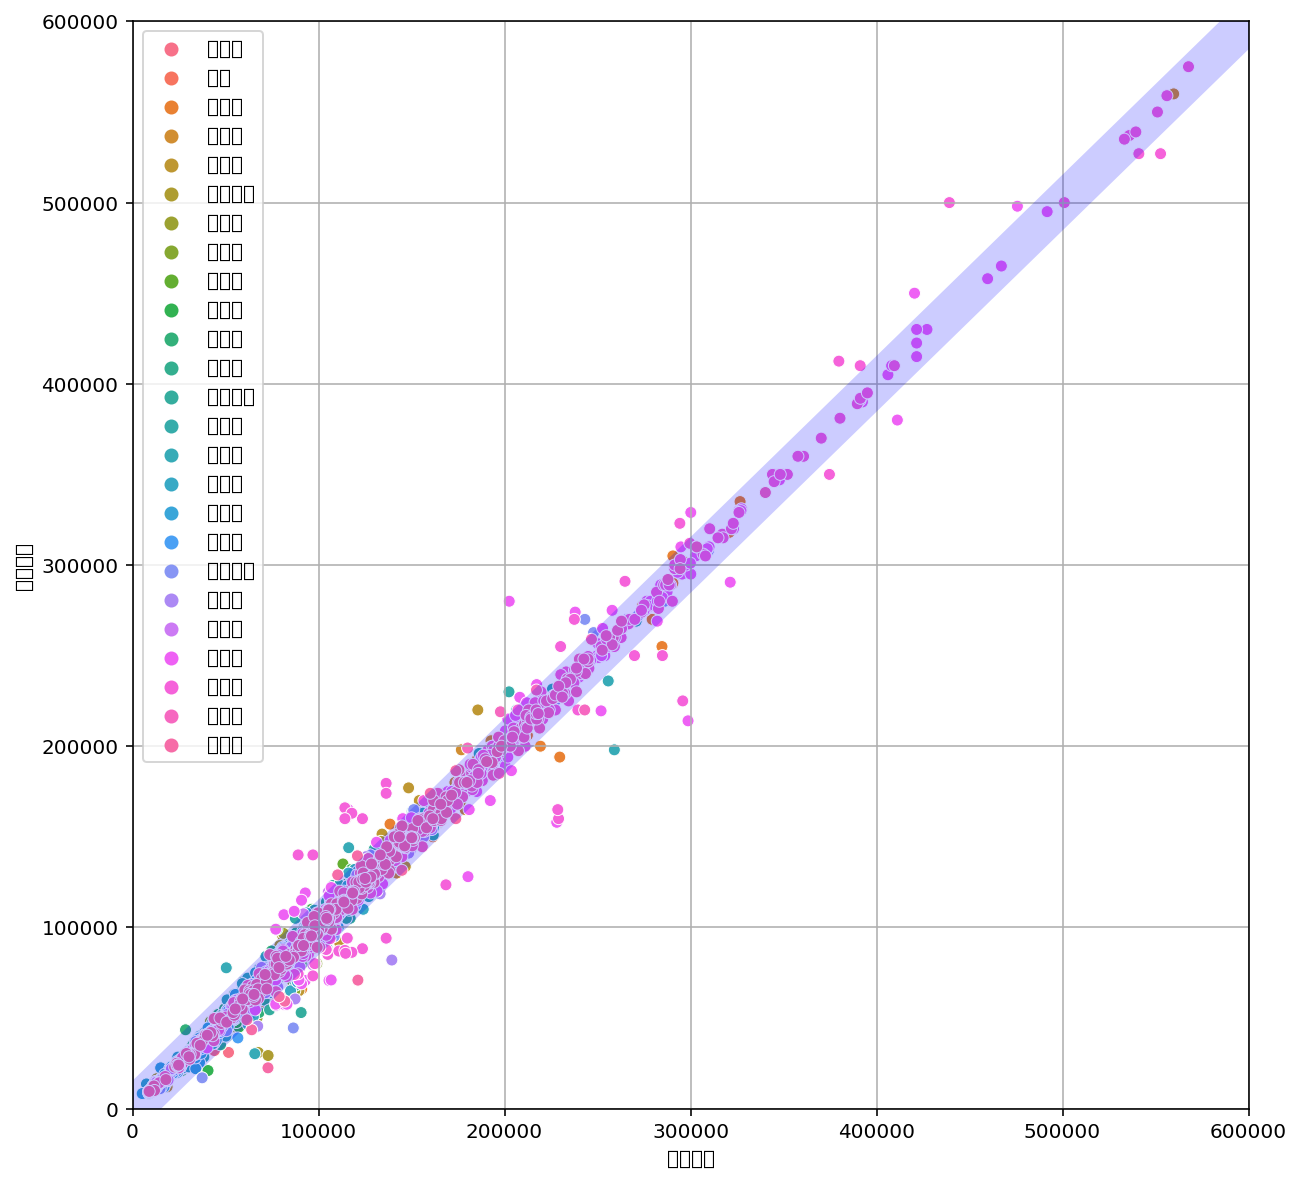

In [ ]:
## BLUE ZONE
plt.figure(figsize=(10,10))
plt.xlim(0,600000)
plt.ylim(0,600000)
sns.scatterplot(df_pred.예측금액, df_pred.거래금액,hue=df_pred.지역코드)
sns.lineplot((0,600000),(0,600000),linewidth=20,color='b',alpha=0.2);

## 2.6 훈련모델 저장

In [ ]:
from sklearn.externals import joblib
# save model
joblib.dump(lightGB, 'lgb.pkl')

['lgb.pkl']

In [ ]:
# load model
lgbm_pickle = joblib.load('lgb.pkl')

In [ ]:
lgbm_pickle

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300000, n_jobs=-1, num_leaves=250, objective=None,
              random_state=1, reg_alpha=1, reg_lambda=1, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgbm_pickle.predict(X_test_encoded.iloc[[1]])

array([113347.852677])